### Gradient Boosting Regressor
#### Este notebook implementa un modelo de Gradient Boosting para predecir la popularidad de canciones de Spotify.
#### Gradient Boosting construye un ensemble de árboles de decisión de forma secuencial, donde cada árbol intenta corregir los errores del anterior.


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [2]:
# Cargar datasets con feature engineering aplicado
train = pd.read_csv("../data/train_fe.csv")
test = pd.read_csv("../data/test_fe.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nColumnas en train: {train.columns.tolist()}")
print(f"\nPrimeras filas del train:")
print(train.head())

Train shape: (79800, 17)
Test shape: (34200, 16)

Columnas en train: ['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']

Primeras filas del train:
                 track_id  popularity  explicit  danceability  energy  \
0  7hUhmkALyQ8SX9mJs5XI3D          22     False         0.305  0.8490   
1  5x59U89ZnjZXuNAAlc8X1u          22     False         0.287  0.1900   
2  70Vng5jLzoJLmeLu3ayBQq          37     False         0.583  0.5090   
3  1cRfzLJapgtwJ61xszs37b           0     False         0.163  0.0368   
4  47d5lYjbiMy0EdMRV8lRou          27     False         0.647  0.9210   

   loudness  speechiness  instrumentalness  valence    tempo  time_signature  \
0   -10.795       0.0549          0.056700   0.3200  141.793               4   
1   -12.030       0.0370      

In [3]:
# Separar features y target
X_train = train.drop(columns=['track_id', 'popularity'])
y_train = train['popularity']

X_test = test.drop(columns=['track_id'])

# Verificar datos
print(f"Valores nulos en X_train: {X_train.isnull().sum().sum()}")
print(f"Valores nulos en y_train: {y_train.isnull().sum()}")
print(f"Valores nulos en X_test: {X_test.isnull().sum().sum()}")

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}")

print(f"\nEstadísticas de la variable target (popularity):")
print(y_train.describe())

Valores nulos en X_train: 0
Valores nulos en y_train: 0
Valores nulos en X_test: 0

Shape X_train: (79800, 15)
Shape y_train: (79800,)
Shape X_test: (34200, 15)

Estadísticas de la variable target (popularity):
count    79800.000000
mean        33.265301
std         22.330871
min          0.000000
25%         17.000000
50%         35.000000
75%         50.000000
max        100.000000
Name: popularity, dtype: float64


### Modelo Base - Gradient Boosting con parámetros por defecto
#### Primero entrenaremos un modelo base para establecer un baseline y entender el comportamiento del algoritmo.


In [4]:
# Entrenar modelo base con parámetros por defecto
print("Entrenando Gradient Boosting con parámetros por defecto...")
gbr_base = GradientBoostingRegressor(random_state=42, verbose=0)
gbr_base.fit(X_train, y_train)

# Predicciones en train
y_train_pred_base = gbr_base.predict(X_train)

# Métricas en train
mse_train_base = mean_squared_error(y_train, y_train_pred_base)
rmse_train_base = np.sqrt(mse_train_base)
mae_train_base = mean_absolute_error(y_train, y_train_pred_base)
r2_train_base = r2_score(y_train, y_train_pred_base)

print("=" * 60)
print("MODELO BASE - Métricas en TRAIN")
print("=" * 60)
print(f"MSE:  {mse_train_base:.4f}")
print(f"RMSE: {rmse_train_base:.4f}")
print(f"MAE:  {mae_train_base:.4f}")
print(f"R²:   {r2_train_base:.4f}")
print(f"\nParámetros del modelo base:")
print(f"  - n_estimators: {gbr_base.n_estimators}")
print(f"  - learning_rate: {gbr_base.learning_rate}")
print(f"  - max_depth: {gbr_base.max_depth}")
print(f"  - min_samples_split: {gbr_base.min_samples_split}")
print(f"  - min_samples_leaf: {gbr_base.min_samples_leaf}")

Entrenando Gradient Boosting con parámetros por defecto...
MODELO BASE - Métricas en TRAIN
MSE:  49.5770
RMSE: 7.0411
MAE:  4.5911
R²:   0.9006

Parámetros del modelo base:
  - n_estimators: 100
  - learning_rate: 0.1
  - max_depth: 3
  - min_samples_split: 2
  - min_samples_leaf: 1


In [ ]:
# Cross-validation del modelo base
print("Realizando validación cruzada (5-fold)...")
cv_scores_base = cross_val_score(gbr_base, X_train, y_train, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1)

rmse_cv_base = np.sqrt(-cv_scores_base)

print("=" * 60)
print("MODELO BASE - Validación Cruzada (5-fold)")
print("=" * 60)
print(f"RMSE por fold: {rmse_cv_base}")
print(f"RMSE medio: {rmse_cv_base.mean():.4f} (+/- {rmse_cv_base.std():.4f})")
print(f"\n Diferencia Train-CV: {abs(rmse_train_base - rmse_cv_base.mean()):.4f}")

Realizando validación cruzada (5-fold)...
MODELO BASE - Validación Cruzada (5-fold)
RMSE por fold: [7.09984771 7.2357043  6.9608123  7.03416516 7.19175464]
RMSE medio: 7.1045 (+/- 0.1004)

📊 Diferencia Train-CV: 0.0634


### Optimización de Hiperparámetros
Vamos a optimizar los siguientes hiperparámetros clave:
- **n_estimators**: Número de árboles en el ensemble
- **learning_rate**: Tasa de aprendizaje (shrinkage)
- **max_depth**: Profundidad máxima de cada árbol
- **min_samples_split**: Mínimo de muestras para dividir un nodo
- **min_samples_leaf**: Mínimo de muestras en una hoja
- **subsample**: Fracción de muestras para entrenar cada árbol
- **max_features**: Número de features a considerar en cada split


In [6]:
# RandomizedSearchCV (más eficiente para muchos hiperparámetros)
# Definir distribuciones de hiperparámetros
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

print("Iniciando búsqueda de hiperparámetros con RandomizedSearchCV...")
print(f"Combinaciones a probar: 50 (muestreo aleatorio)")
print(f"Esto puede tardar varios minutos...\n")

# RandomizedSearchCV para búsqueda más eficiente
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42, verbose=0),
    param_distributions=param_distributions,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\n✅ Búsqueda completada")
print(f"\nMejores hiperparámetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor RMSE en CV: {np.sqrt(-random_search.best_score_):.4f}")


Iniciando búsqueda de hiperparámetros con RandomizedSearchCV...
Combinaciones a probar: 50 (muestreo aleatorio)
Esto puede tardar varios minutos...

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=20, n_estimators=100, subsample=0.6; total time=   8.6s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=20, n_estimators=100, subsample=0.6; total time=   8.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=20, n_estimators=100, subsample=0.6; total time=   8.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=20, n_estimators=100, subsample=0.6; total time=   8.5s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=4, min_samples_split=20, n_estimators=100, subsample=0.6; total time=   8.5s
[CV] END learn

PASO 1 — Identificar qué variables categóricas tienen alta cardinalidad

Ya identificamos las 3 columnas problemáticas:
- _artists_
- album_name
- track_name

Ahora definimos qué tipo de transformación aplicar a cada una, sabiendo que no podemos hacer One-Hot Encoding por la cantidad enorme de valores distintos.

Para _artists_ vamos a utilizar Count Encoding.  
Para album_name vamos a utilizar Target Encoding (media de popularidad por álbum).  
Para track_name vamos a utilizar Length Encoding.

In [7]:
# Entrenar modelo optimizado
# Obtener el mejor modelo
gbr_optimized = random_search.best_estimator_

# Predicciones en train
y_train_pred_opt = gbr_optimized.predict(X_train)

# Métricas en train
mse_train_opt = mean_squared_error(y_train, y_train_pred_opt)
rmse_train_opt = np.sqrt(mse_train_opt)
mae_train_opt = mean_absolute_error(y_train, y_train_pred_opt)
r2_train_opt = r2_score(y_train, y_train_pred_opt)

print("=" * 60)
print("MODELO OPTIMIZADO - Métricas en TRAIN")
print("=" * 60)
print(f"MSE:  {mse_train_opt:.4f}")
print(f"RMSE: {rmse_train_opt:.4f}")
print(f"MAE:  {mae_train_opt:.4f}")
print(f"R²:   {r2_train_opt:.4f}")

MODELO OPTIMIZADO - Métricas en TRAIN
MSE:  8.5626
RMSE: 2.9262
MAE:  1.7770
R²:   0.9828


In [8]:
# Comparación modelos
# Comparar modelo base vs optimizado
comparison_df = pd.DataFrame({
    'Modelo': ['Base (parámetros default)', 'Optimizado (RandomizedSearchCV)'],
    'RMSE Train': [rmse_train_base, rmse_train_opt],
    'RMSE CV': [rmse_cv_base.mean(), np.sqrt(-random_search.best_score_)],
    'MAE Train': [mae_train_base, mae_train_opt],
    'R² Train': [r2_train_base, r2_train_opt]
})

print("\n" + "=" * 90)
print("COMPARACIÓN DE MODELOS")
print("=" * 90)
print(comparison_df.to_string(index=False))

# Calcular mejora porcentual
mejora_rmse = ((rmse_cv_base.mean() - np.sqrt(-random_search.best_score_)) / rmse_cv_base.mean()) * 100
print(f"\n✅ Mejora en RMSE CV: {mejora_rmse:.2f}%")


COMPARACIÓN DE MODELOS
                         Modelo  RMSE Train  RMSE CV  MAE Train  R² Train
      Base (parámetros default)    7.041091 7.104457   4.591100  0.900580
Optimizado (RandomizedSearchCV)    2.926198 5.051032   1.776983  0.982829

✅ Mejora en RMSE CV: 28.90%


Generando curva de aprendizaje...


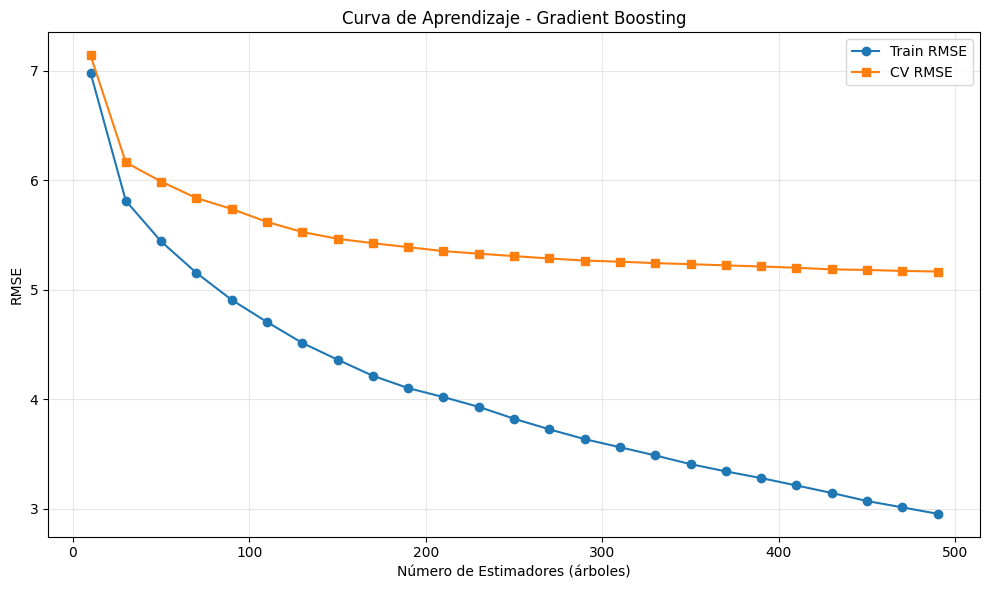

✅ Curva generada


In [9]:
# Curva de aprendizaje
# Analizar el aprendizaje del modelo optimizado
train_scores = []
cv_scores = []
n_estimators_range = range(10, gbr_optimized.n_estimators + 1, 20)

print("Generando curva de aprendizaje...")
for n_est in n_estimators_range:
    gbr_temp = GradientBoostingRegressor(
        n_estimators=n_est,
        learning_rate=gbr_optimized.learning_rate,
        max_depth=gbr_optimized.max_depth,
        min_samples_split=gbr_optimized.min_samples_split,
        min_samples_leaf=gbr_optimized.min_samples_leaf,
        subsample=gbr_optimized.subsample,
        max_features=gbr_optimized.max_features,
        random_state=42,
        verbose=0
    )
    gbr_temp.fit(X_train, y_train)
    
    y_pred = gbr_temp.predict(X_train)
    train_scores.append(np.sqrt(mean_squared_error(y_train, y_pred)))
    
    cv_score = cross_val_score(gbr_temp, X_train, y_train, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_scores.append(np.sqrt(-cv_score.mean()))

# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Train RMSE', marker='o')
plt.plot(n_estimators_range, cv_scores, label='CV RMSE', marker='s')
plt.xlabel('Número de Estimadores (árboles)')
plt.ylabel('RMSE')
plt.title('Curva de Aprendizaje - Gradient Boosting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Curva generada")


Top 10 Features más importantes:
              feature  importance
album_mean_popularity    0.910785
genre_mean_popularity    0.038691
         artist_count    0.014502
     instrumentalness    0.005656
             loudness    0.005563
         danceability    0.004998
               energy    0.004188
              valence    0.004139
                tempo    0.004098
          speechiness    0.003695


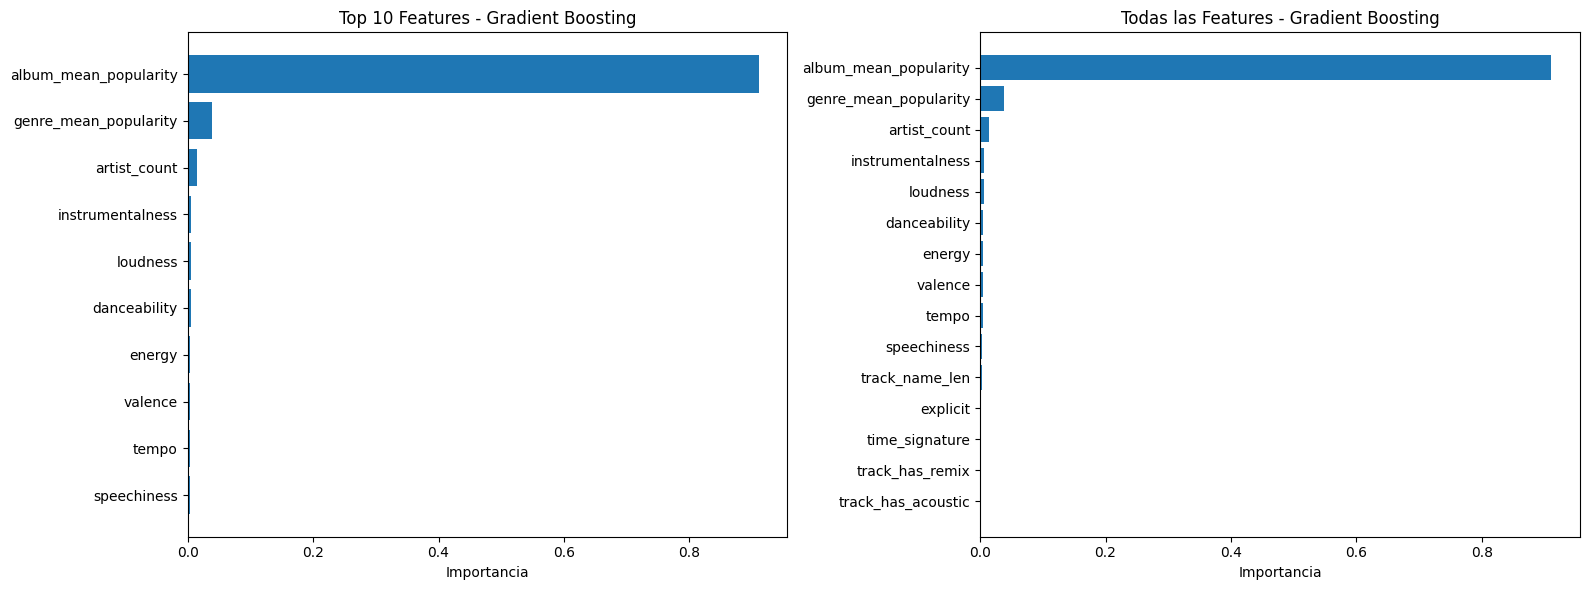

In [10]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gbr_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features más importantes:")
print(feature_importance.head(10).to_string(index=False))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10
axes[0].barh(feature_importance['feature'].head(10), 
             feature_importance['importance'].head(10))
axes[0].set_xlabel('Importancia')
axes[0].set_title('Top 10 Features - Gradient Boosting')
axes[0].invert_yaxis()

# Todas las features
axes[1].barh(feature_importance['feature'], 
             feature_importance['importance'])
axes[1].set_xlabel('Importancia')
axes[1].set_title('Todas las Features - Gradient Boosting')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

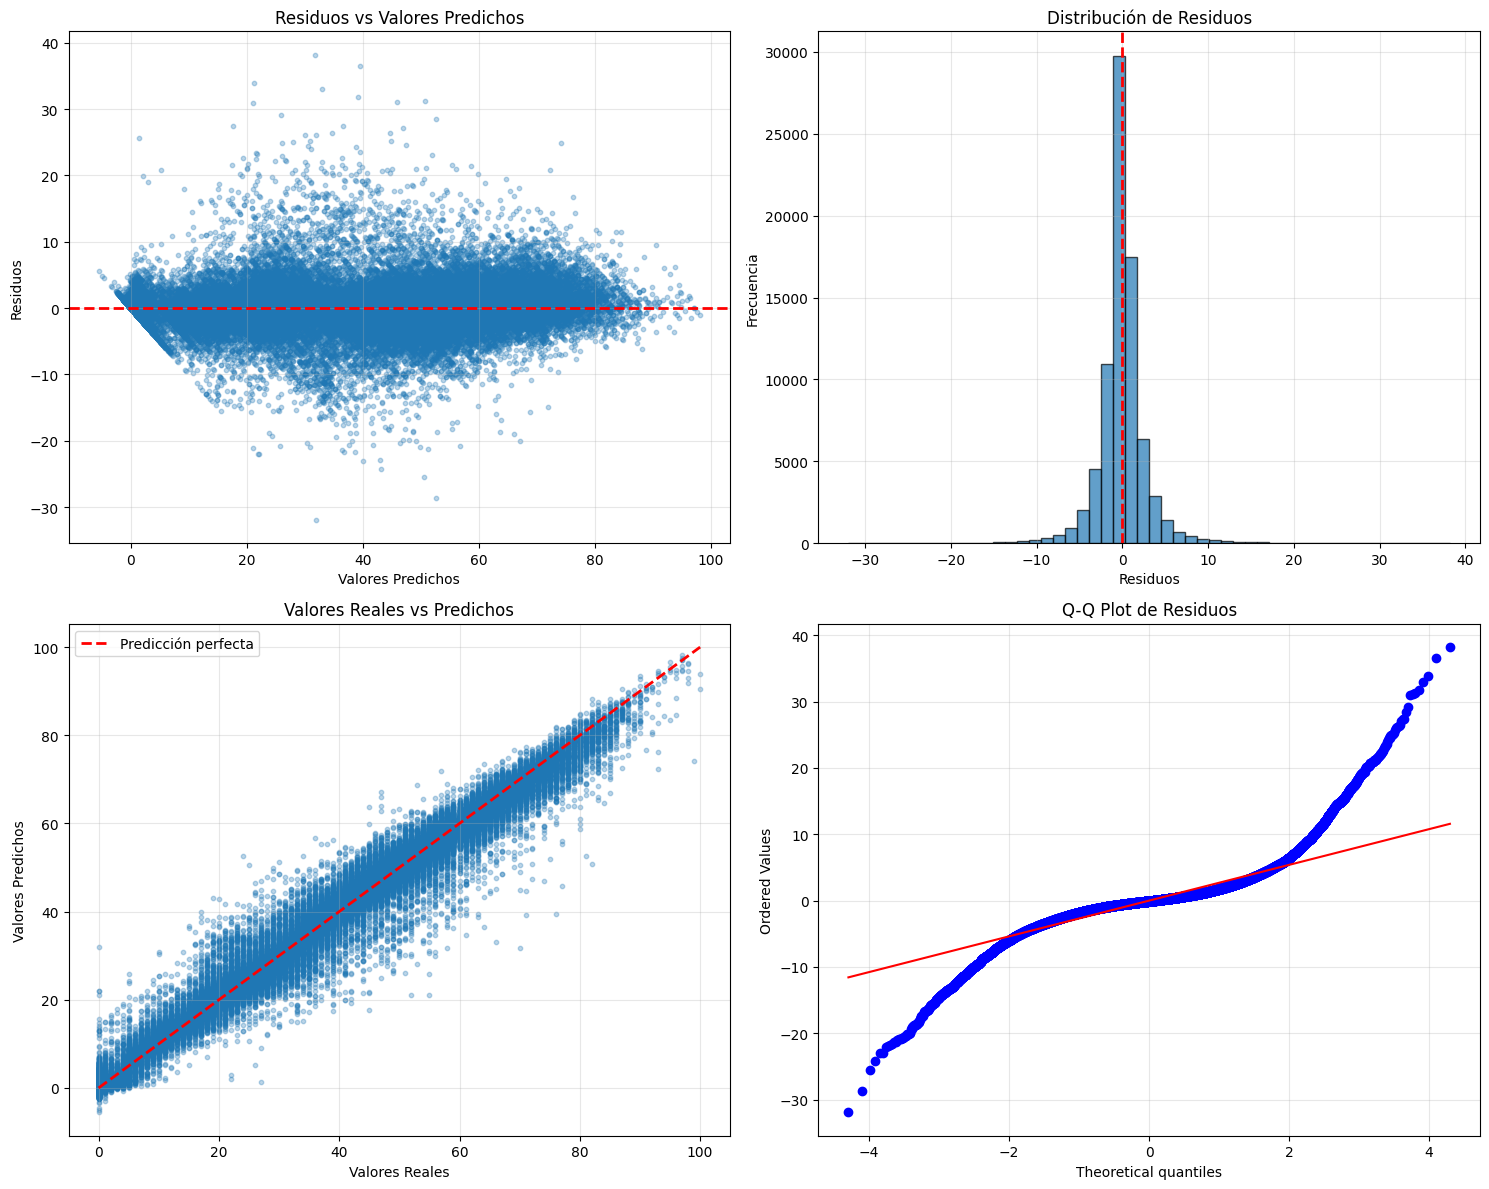


📊 Estadísticas de Residuos:
   Media: 0.0005
   Mediana: -0.0805
   Desviación estándar: 2.9262
   Min: -31.9332
   Max: 38.2089


In [ ]:
# Calcular residuos
residuals = y_train - y_train_pred_opt

# Gráficos de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuos vs valores predichos
axes[0, 0].scatter(y_train_pred_opt, residuals, alpha=0.3, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Valores Predichos')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].set_title('Residuos vs Valores Predichos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histograma de residuos
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuos')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Valores reales vs predichos
axes[1, 0].scatter(y_train, y_train_pred_opt, alpha=0.3, s=10)
axes[1, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Predicción perfecta')
axes[1, 0].set_xlabel('Valores Reales')
axes[1, 0].set_ylabel('Valores Predichos')
axes[1, 0].set_title('Valores Reales vs Predichos')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot (normalidad de residuos)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot de Residuos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Estadísticas de Residuos:")
print(f"   Media: {residuals.mean():.4f}")
print(f"   Mediana: {residuals.median():.4f}")
print(f"   Desviación estándar: {residuals.std():.4f}")
print(f"   Min: {residuals.min():.4f}")
print(f"   Max: {residuals.max():.4f}")


📊 Error por Rango de Popularidad:
 Rango     RMSE      MAE  Cantidad
  0-20 2.201076 1.274402     23904
 20-40 2.958817 1.805310     23189
 40-60 3.103211 1.926446     23175
 60-80 3.700560 2.505817      8845
80-100 5.419924 3.882504       687


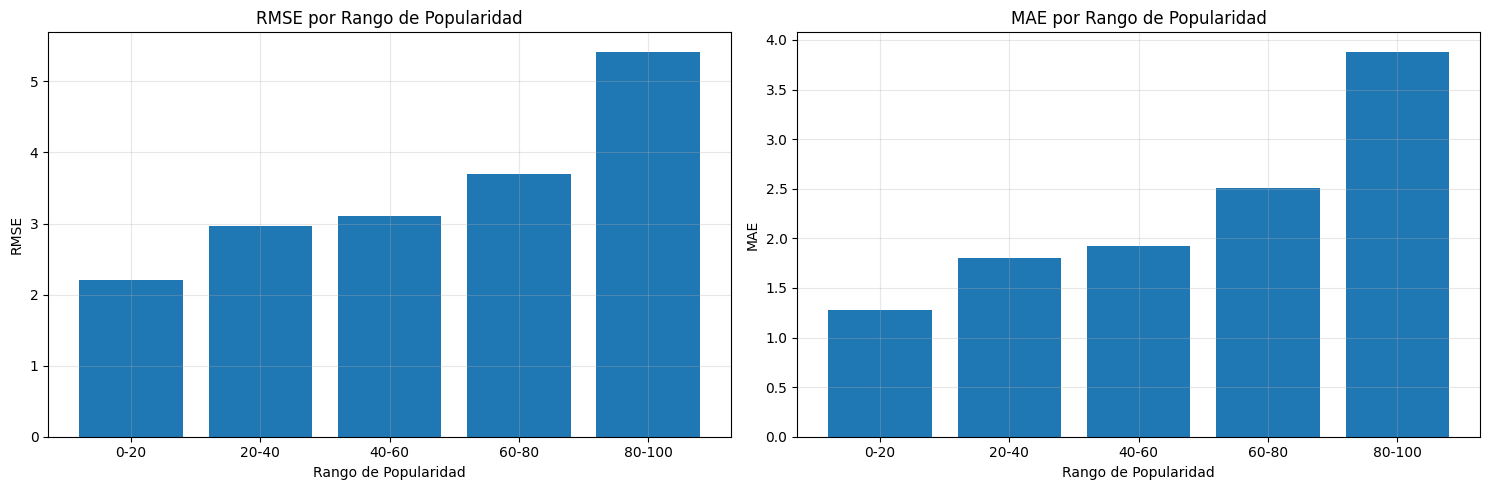

In [ ]:
# Analizar errores por rango de popularidad
y_train_copy = y_train.copy()
y_train_copy.index = range(len(y_train_copy))

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
y_train_binned = pd.cut(y_train_copy, bins=bins, labels=labels, include_lowest=True)

error_by_range = pd.DataFrame({
    'Rango': labels,
    'RMSE': [np.sqrt(mean_squared_error(
        y_train_copy[y_train_binned == label],
        y_train_pred_opt[y_train_binned == label]
    )) if (y_train_binned == label).sum() > 0 else 0 for label in labels],
    'MAE': [mean_absolute_error(
        y_train_copy[y_train_binned == label],
        y_train_pred_opt[y_train_binned == label]
    ) if (y_train_binned == label).sum() > 0 else 0 for label in labels],
    'Cantidad': [(y_train_binned == label).sum() for label in labels]
})

print("\n Error por Rango de Popularidad:")
print(error_by_range.to_string(index=False))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(error_by_range['Rango'], error_by_range['RMSE'])
axes[0].set_xlabel('Rango de Popularidad')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE por Rango de Popularidad')
axes[0].grid(True, alpha=0.3)

axes[1].bar(error_by_range['Rango'], error_by_range['MAE'])
axes[1].set_xlabel('Rango de Popularidad')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE por Rango de Popularidad')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Generando predicciones en el conjunto de test...

📊 Predicciones en TEST:
                 track_id  popularity_predicha
0  6KwkVtXm8OUp2XffN5k7lY            46.811444
1  2dp5I5MJ8bQQHDoFaNRFtX            13.659710
2  5avw06usmFkFrPjX8NxC40            -1.035412
3  75hT0hvlESnDJstem0JgyR            -0.247145
4  4bY2oZGA5Br3pTE1Jd1IfY            30.621542
5  2zQt5C0AIv27RhfJCRZdZ4            39.960960
6  6BctgCJXlgxYeR0ObhLdtR            25.789670
7  1LDQFdGTEXOnycDC8CJ5p1            33.102796
8  2DDR5F7bHFJBiX6lPPsT8O            37.776592
9  2ScU6iEvgb0TIuKiyem9rg            52.273699

📈 Estadísticas de predicciones en test:
count    34200.000000
mean        31.605500
std         19.429181
min         -7.134360
25%         20.990916
50%         33.458973
75%         42.858195
max         95.652495
Name: popularity_predicha, dtype: float64


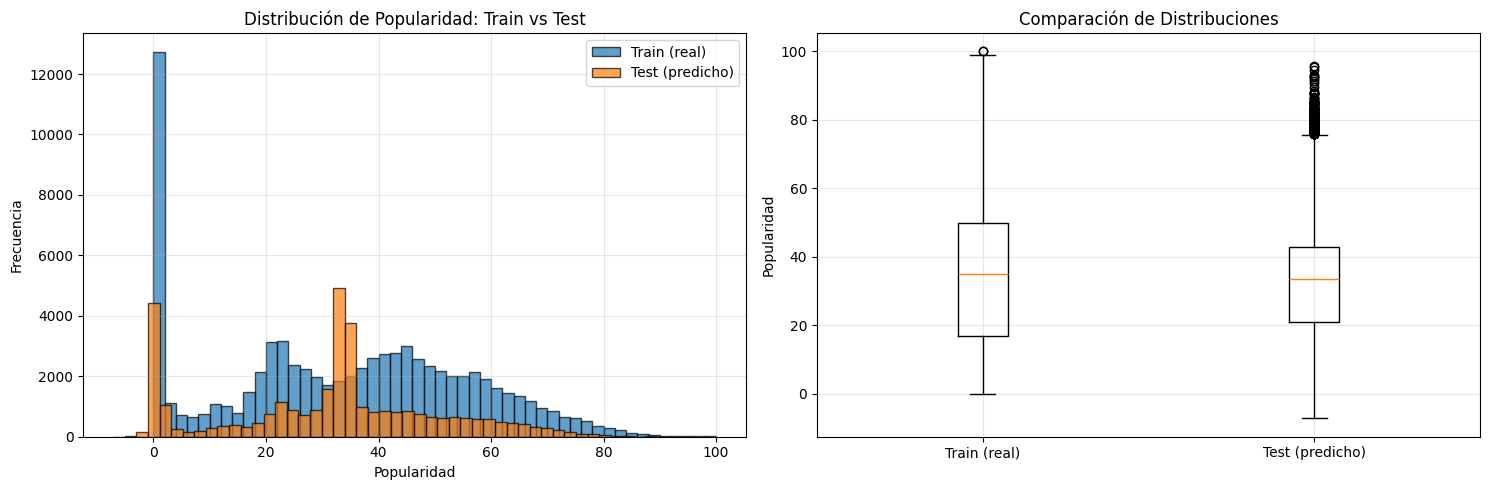


✅ Predicciones guardadas en: ../data/predictions_gradient_boosting.csv


In [ ]:
# Generar predicciones para el conjunto de test
print("Generando predicciones en el conjunto de test...")
y_test_pred = gbr_optimized.predict(X_test)

# Crear DataFrame con predicciones
predictions_df = pd.DataFrame({
    'track_id': test['track_id'],
    'popularity_predicha': y_test_pred
})

print("\n Predicciones en TEST:")
print(predictions_df.head(10))

print(f"\n Estadísticas de predicciones en test:")
print(predictions_df['popularity_predicha'].describe())

# Visualizar distribución de predicciones
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(y_train, bins=50, alpha=0.7, label='Train (real)', edgecolor='black')
axes[0].hist(y_test_pred, bins=50, alpha=0.7, label='Test (predicho)', edgecolor='black')
axes[0].set_xlabel('Popularidad')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Popularidad: Train vs Test')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot([y_train, y_test_pred], labels=['Train (real)', 'Test (predicho)'])
axes[1].set_ylabel('Popularidad')
axes[1].set_title('Comparación de Distribuciones')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar predicciones
predictions_df.to_csv('../data/predictions_gradient_boosting.csv', index=False)
print("\n✅ Predicciones guardadas en: ../data/predictions_gradient_boosting.csv")

In [ ]:
# Analizar los resultados de todos los modelos probados en RandomizedSearchCV
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['mean_rmse'] = np.sqrt(-cv_results['mean_test_score'])
cv_results['std_rmse'] = cv_results['std_test_score'] / (2 * cv_results['mean_rmse'])

# Top 10 mejores modelos
top_10_models = cv_results.nsmallest(10, 'mean_rmse')[
    ['mean_rmse', 'std_rmse', 'param_n_estimators', 'param_learning_rate', 
     'param_max_depth', 'param_subsample']
]

print("\n Top 10 Mejores Configuraciones de Hiperparámetros:")
print(top_10_models.to_string(index=False))


📊 Top 10 Mejores Configuraciones de Hiperparámetros:
 mean_rmse  std_rmse  param_n_estimators  param_learning_rate  param_max_depth  param_subsample
  5.051032  0.072593                 500                 0.20                7              0.9
  5.289061  0.073017                 500                 0.20                5              1.0
  5.603185  0.034460                 100                 0.20                7              0.8
  5.942228  0.072192                 300                 0.05                6              0.9
  6.057648  0.068922                 200                 0.10                5              0.7
  6.232075  0.086004                 300                 0.10                4              1.0
  6.247517  0.070994                 500                 0.05                7              0.9
  6.288860  0.034350                 500                 0.10                3              0.6
  6.341572  0.097419                 300                 0.20                7    

In [ ]:
# Cell 18: Resumen final
print("\n" + "=" * 80)
print("RESUMEN FINAL - GRADIENT BOOSTING REGRESSOR")
print("=" * 80)

print(f"\n DATASET:")
print(f"   - Muestras de entrenamiento: {len(X_train):,}")
print(f"   - Muestras de test: {len(X_test):,}")
print(f"   - Número de features: {X_train.shape[1]}")

print(f"\n MODELO OPTIMIZADO:")
print(f"   - n_estimators: {gbr_optimized.n_estimators}")
print(f"   - learning_rate: {gbr_optimized.learning_rate}")
print(f"   - max_depth: {gbr_optimized.max_depth}")
print(f"   - min_samples_split: {gbr_optimized.min_samples_split}")
print(f"   - min_samples_leaf: {gbr_optimized.min_samples_leaf}")
print(f"   - subsample: {gbr_optimized.subsample}")
print(f"   - max_features: {gbr_optimized.max_features}")

print(f"\n MÉTRICAS EN TRAIN:")
print(f"   - RMSE: {rmse_train_opt:.4f}")
print(f"   - MAE:  {mae_train_opt:.4f}")
print(f"   - R²:   {r2_train_opt:.4f}")

print(f"\n VALIDACIÓN CRUZADA (5-fold):")
print(f"   - RMSE: {np.sqrt(-random_search.best_score_):.4f}")

print(f"\n COMPARACIÓN CON MODELO BASE:")
print(f"   - Mejora en RMSE CV: {mejora_rmse:.2f}%")
print(f"   - RMSE Base: {rmse_cv_base.mean():.4f}")
print(f"   - RMSE Optimizado: {np.sqrt(-random_search.best_score_):.4f}")

print(f"\n TOP 3 FEATURES MÁS IMPORTANTES:")
for idx, (_, row) in enumerate(feature_importance.head(3).iterrows(), 1):
    print(f"   {idx}. {row['feature']}: {row['importance']:.4f}")

print(f"\n PREDICCIONES:")
print(f"   - Archivo: predictions_gradient_boosting.csv")
print(f"   - Rango: [{y_test_pred.min():.2f}, {y_test_pred.max():.2f}]")
print(f"   - Media: {y_test_pred.mean():.2f}")


RESUMEN FINAL - GRADIENT BOOSTING REGRESSOR

📊 DATASET:
   - Muestras de entrenamiento: 79,800
   - Muestras de test: 34,200
   - Número de features: 15

🌲 MODELO OPTIMIZADO:
   - n_estimators: 500
   - learning_rate: 0.2
   - max_depth: 7
   - min_samples_split: 20
   - min_samples_leaf: 4
   - subsample: 0.9
   - max_features: None

📈 MÉTRICAS EN TRAIN:
   - RMSE: 2.9262
   - MAE:  1.7770
   - R²:   0.9828

🔄 VALIDACIÓN CRUZADA (5-fold):
   - RMSE: 5.0510

📊 COMPARACIÓN CON MODELO BASE:
   - Mejora en RMSE CV: 28.90%
   - RMSE Base: 7.1045
   - RMSE Optimizado: 5.0510

🎯 TOP 3 FEATURES MÁS IMPORTANTES:
   1. album_mean_popularity: 0.9108
   2. genre_mean_popularity: 0.0387
   3. artist_count: 0.0145

📁 PREDICCIONES:
   - Archivo: predictions_gradient_boosting.csv
   - Rango: [-7.13, 95.65]
   - Media: 31.61


In [17]:
# Generar CSV con predicciones finales (solo ID y Popularity)
predictions_final = pd.DataFrame({
    'track_id': test['track_id'],
    'popularity': y_test_pred
})

# Guardar el archivo
predictions_final.to_csv('../data/predictions_gradient_boosting.csv', index=False)

print("✅ Predicciones guardadas exitosamente")
print(f"\nArchivo: predictions_gradient_boosting.csv")
print(f"Columnas: {list(predictions_final.columns)}")
print(f"Cantidad de predicciones: {len(predictions_final)}")
print(f"\nPrimeras 10 filas:")
print(predictions_final.head(10))

✅ Predicciones guardadas exitosamente

Archivo: predictions_gradient_boosting.csv
Columnas: ['track_id', 'popularity']
Cantidad de predicciones: 34200

Primeras 10 filas:
                 track_id  popularity
0  6KwkVtXm8OUp2XffN5k7lY   46.811444
1  2dp5I5MJ8bQQHDoFaNRFtX   13.659710
2  5avw06usmFkFrPjX8NxC40   -1.035412
3  75hT0hvlESnDJstem0JgyR   -0.247145
4  4bY2oZGA5Br3pTE1Jd1IfY   30.621542
5  2zQt5C0AIv27RhfJCRZdZ4   39.960960
6  6BctgCJXlgxYeR0ObhLdtR   25.789670
7  1LDQFdGTEXOnycDC8CJ5p1   33.102796
8  2DDR5F7bHFJBiX6lPPsT8O   37.776592
9  2ScU6iEvgb0TIuKiyem9rg   52.273699
